In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!wget http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz

--2022-06-17 11:37:01--  http://www.svcl.ucsd.edu/projects/anomaly/UCSD_Anomaly_Dataset.tar.gz
Resolving www.svcl.ucsd.edu (www.svcl.ucsd.edu)... 169.228.63.130
Connecting to www.svcl.ucsd.edu (www.svcl.ucsd.edu)|169.228.63.130|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 740306953 (706M) [application/x-gzip]
Saving to: ‘UCSD_Anomaly_Dataset.tar.gz’

UCSD_Anomaly_Datase 100%[===================>] 706.01M  17.7MB/s    in 48s     

2022-06-17 11:37:49 (14.8 MB/s) - ‘UCSD_Anomaly_Dataset.tar.gz’ saved [740306953/740306953]



In [ ]:
!tar -xvf UCSD_Anomaly_Dataset.tar.gz

Streaming output truncated to the last 5000 lines.
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/139.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/002.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/060.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/085.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/067.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/127.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/131.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/012.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/148.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/144.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/015.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/009.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/102.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/143.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/078.bmp
UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/017.bmp
UCSD_

### Feature Extraction

In [ ]:
import sys
import os
import requests

import torch
import numpy as np

import matplotlib.pyplot as plt
from PIL import Image

# check whether run in Colab
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install timm==0.4.5  # 0.3.2 does not work in Colab
    !git clone https://github.com/facebookresearch/mae.git
    sys.path.append('./mae')
else:
    sys.path.append('..')
import models_mae

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 287 kB 4.8 MB/s 
Cloning into 'mae'...
remote: Enumerating objects: 39, done.
remote: Total 39 (delta 0), reused 0 (delta 0), pack-reused 39
Unpacking objects: 100% (39/39), done.


In [ ]:
# define the utils

imagenet_mean = np.array([0.485, 0.456, 0.406])
imagenet_std = np.array([0.229, 0.224, 0.225])

def show_image(image, title=''):
    # image is [H, W, 3]
    assert image.shape[2] == 3
    plt.imshow(torch.clip((image * imagenet_std + imagenet_mean) * 255, 0, 255).int())
    plt.title(title, fontsize=16)
    plt.axis('off')
    return

def prepare_model(chkpt_dir, arch='mae_vit_large_patch16'):
    # build model
    model = getattr(models_mae, arch)()
    # load model
    checkpoint = torch.load(chkpt_dir, map_location='cpu')
    msg = model.load_state_dict(checkpoint['model'], strict=False)
    print(msg)
    return model

def run_one_image(img, model):
    x = torch.tensor(img)

    # make it a batch-like
    x = x.unsqueeze(dim=0)
    x = torch.einsum('nhwc->nchw', x)

    # run MAE
    loss, y, mask = model(x.float(), mask_ratio=0)
    y = model.unpatchify(y)
    y = torch.einsum('nchw->nhwc', y).detach().cpu()

    # visualize the mask
    mask = mask.detach()
    mask = mask.unsqueeze(-1).repeat(1, 1, model.patch_embed.patch_size[0]**2 *3)  # (N, H*W, p*p*3)
    mask = model.unpatchify(mask)  # 1 is removing, 0 is keeping
    mask = torch.einsum('nchw->nhwc', mask).detach().cpu()
    
    x = torch.einsum('nchw->nhwc', x)

    # masked image
    im_masked = x * (1 - mask)

    # MAE reconstruction pasted with visible patches
    im_paste = x * (1 - mask) + y * mask

    # make the plt figure larger
    plt.rcParams['figure.figsize'] = [24, 24]

    plt.subplot(1, 4, 1)
    show_image(x[0], "original")

    plt.subplot(1, 4, 2)
    show_image(im_masked[0], "masked")

    plt.subplot(1, 4, 3)
    show_image(y[0], "reconstruction")

    plt.subplot(1, 4, 4)
    show_image(im_paste[0], "reconstruction + visible")

    plt.show()

In [ ]:
# This is an MAE model trained with an extra GAN loss for more realistic generation (ViT-Large, training mask ratio=0.75)

# download checkpoint if not exist
!wget -nc https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth

chkpt_dir = 'mae_visualize_vit_large_ganloss.pth'
model_mae_gan = prepare_model('mae_visualize_vit_large_ganloss.pth', 'mae_vit_large_patch16')
print('Model loaded.')

--2022-06-18 12:44:39--  https://dl.fbaipublicfiles.com/mae/visualize/mae_visualize_vit_large_ganloss.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1318315181 (1.2G) [binary/octet-stream]
Saving to: ‘mae_visualize_vit_large_ganloss.pth’

mae_visualize_vit_l 100%[===================>]   1.23G  31.3MB/s    in 39s     

2022-06-18 12:45:18 (32.2 MB/s) - ‘mae_visualize_vit_large_ganloss.pth’ saved [1318315181/1318315181]

<All keys matched successfully>
Model loaded.


In [ ]:
activation = {}
def get_features(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [ ]:
model_mae_gan.decoder_embed.register_forward_hook(get_features('Linear'))

In [ ]:
model_mae_gan.eval()

MaskedAutoencoderViT(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
  )
  (blocks): ModuleList(
    (0): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, out_features=3072, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=1024, out_features=1024, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=1024, out_features=4096, bias=True)
        (act): GELU()
        (fc2): Linear(in_features=4096, out_features=1024, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
    (1): Block(
      (norm1): LayerNorm((1024,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=1024, o

In [ ]:
def image_vector(img_url):
  # load an image
#img_jpg_path = '/content/drive/MyDrive/swathi/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train001/jpg'
  img_url = img_url
#img_url2 = 'https://user-images.githubusercontent.com/11435359/147738734-196fd92f-9260-48d5-ba7e-bf103d29364d.jpg' # fox, from ILSVRC2012_val_00046145
# img_url = 'https://user-images.githubusercontent.com/11435359/147743081-0428eecf-89e5-4e07-8da5-a30fd73cc0ba.jpg' # cucumber, from ILSVRC2012_val_00047851

  img = Image.open(img_url).convert('RGB')
  img = img.resize((224, 224))
  img = np.array(img) / 255
#img = np.reshape(img, [224,224,3])
  print(img.shape)
#assert img.shape == (224, 224)

  print(type(img))
  print(type(imagenet_mean))
# normalize by ImageNet mean and std
  img = img - imagenet_mean
  print(imagenet_mean)
  img = img / imagenet_std
  x = torch.tensor(img)

    # make it a batch-like
  x = x.unsqueeze(dim=0)
  x = torch.einsum('nhwc->nchw', x)

    # run MAE

  loss, y, mask = model_mae_gan(x.float(), mask_ratio=0)
  return activation['Linear']
  
# plt.rcParams['figure.figsize'] = [5, 5]
# abc = show_image(torch.tensor(img))

In [ ]:
image_vector("/content/UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test001/001.tif")

### Feature Vectorization for training

In [ ]:
from glob import glob
import os
import pickle
folder_dir  = glob("/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/*/", recursive = True)
# folder_dir = "/content"
not_list = []
for folder in folder_dir:
  ls_test=[]
  vec_test = []
  if folder in not_list:
    continue
  filename = f"/content/drive/MyDrive/vec_test{folder}"
  os.makedirs(os.path.dirname(filename), exist_ok=True)
  filename = f"/content/drive/MyDrive/ls_test{folder}"
  os.makedirs(os.path.dirname(filename), exist_ok=True)
  for images in os.listdir(folder):
      # check if the image ends with tif
      if (images.endswith(".tif")):
          ls_test.append(f"{folder}{images}")
          print(f"{folder}{images}")
          vec_test.append(image_vector(f"{folder}{images}"))

# l = [1,2,3,4,5]
  with open(f"/content/drive/MyDrive/vec_test{folder}/vec_test.pickle", "wb") as fp:   #Pickling
    pickle.dump(vec_test, fp)
  with open(f"/content/drive/MyDrive/ls_test{folder}/ls_test.pickle", "wb") as fp:   #Pickling
    pickle.dump(ls_test, fp)
  not_list.append(folder)

In [ ]:
len(vec_train)

2550

### Feature Vectorization for Testing

In [ ]:
from glob import glob
import os
import pickle
folder_dir  = glob("/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/*/", recursive = True)
# folder_dir = "/content"

for folder in folder_dir:
  ls_test=[]
  vec_test = []
  if folder in not_list:
    continue
  filename = f"/content/drive/MyDrive/vec_test{folder}"
  os.makedirs(os.path.dirname(filename), exist_ok=True)
  filename = f"/content/drive/MyDrive/ls_test{folder}"
  os.makedirs(os.path.dirname(filename), exist_ok=True)
  for images in os.listdir(folder):
      # check if the image ends with tif
      if (images.endswith(".tif")):
          ls_test.append(f"{folder}{images}")
          print(f"{folder}{images}")
          vec_test.append(image_vector(f"{folder}{images}"))

# l = [1,2,3,4,5]
  with open(f"/content/drive/MyDrive/vec_test{folder}/vec_test.pickle", "wb") as fp:   #Pickling
    pickle.dump(vec_test, fp)
  with open(f"/content/drive/MyDrive/ls_test{folder}/ls_test.pickle", "wb") as fp:   #Pickling
    pickle.dump(ls_test, fp)
  not_list.append(folder)

### Combining Train Features

In [ ]:
from glob import glob
folder_dir  = glob("/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/*/", recursive = True)

In [ ]:
folder_dir

In [ ]:
import pickle
import os
vec = []
ls =[]
ls_path  = "/content/drive/MyDrive/ls_test/"
vec_path = "/content/drive/MyDrive/vec_test/"
for folder in  folder_dir:
  end="/".join(folder.split('/')[5:])
  print(end)
  print(folder)
  with open(f"{ls_path}{folder}ls_test.pickle", "rb") as fp:  #Pickling
# print(file)
    l = pickle.load(fp)
  ls.extend(l)
  with open(f"{vec_path}{folder}vec_test.pickle", "rb") as fp:  #Pickling
# print(file)
    v = pickle.load(fp)
  vec.extend(v)

Test004_gt/
/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test004_gt/
Test009/
/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test009/
Test006/
/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test006/
Test007_gt/
/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test007_gt/
Test012/
/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test012/
Test011/
/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test011/
Test007/
/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test007/
Test003_gt/
/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test003_gt/
Test001_gt/
/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test001_gt/
Test005/
/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test005/
Test005_gt/
/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test005_gt/
Test006_gt/
/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test006_gt/
Test002/
/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test002/
Test010/
/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test010/
Test011_gt/
/content/UCSD_

In [ ]:
with open(f"/content/drive/MyDrive/vec_test.pickle", "wb") as fp:  #Pickling
# print(file)
    pickle.dump(vec,fp)
with open(f"/content/drive/MyDrive/ls_test.pickle", "wb") as fp:  #Pickling
# print(file)
    pickle.dump(ls,fp)

In [ ]:
import numpy as np
import pickle
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import Normalizer

In [ ]:
#vec_flatten contains 1 dimensional feature vector for train image
with open(f"/content/drive/MyDrive/vec_train.pickle", "rb") as fp:  #Pickling
# print(file)
    vec_train = pickle.load(fp)
vec_flatten_train = []
for i in vec_train:
  vec_flatten_train.append(i.flatten().numpy())

In [ ]:
#vec_flatten_test contains 1 dimensional feature vector for test image
with open(f"/content/drive/MyDrive/vec_test.pickle", "rb") as fp:  #Pickling
# print(file)
    vec_test = pickle.load(fp)
vec_flatten_test = []
for i in vec_test:
  vec_flatten_test.append(i.flatten().numpy())

In [ ]:
#gt
test1=[1]*60+[-1]*120
test2=[1]*94+[-1]*86
test3=[-1]*146+[1]*4
test4=[1]*30+[-1]*150
test5=[-1]*129+[1]*21
test6=[-1]*159+[1]*21
test7=[1]*45+[-1]*(180-46+1)
test8=[-1]*180
test9=[-1]*120
test10=[-1]*150
test11=[-1]*180
test12=[1]*87+[-1]*(180-88+1)

frame_gt_list=test1+test2+test3+test4+test5+test6+test7+test8+test9+test10+test11+test12

In [ ]:
with open("/content/drive/MyDrive/ls_test.pickle", "rb") as fp:   #Pickling

  ls_test = pickle.load(fp)

gt = ['Test001','Test002','Test003','Test004','Test005','Test006','Test007','Test008','Test009','Test010','Test011','Test012']
original =[]
for i in ls_test:
  if i.split("/")[-2] in gt:
    original.append(-1)
  else:
    original.append(1)
#original list contains ground truth values 

 Evaluation using One-class SVM

In [ ]:
#model loading and configuration
from sklearn.svm import OneClassSVM
model = OneClassSVM(kernel="poly",nu=0.05,degree=2)
#from sklearn.model_selection import GridSearchCV

In [ ]:
search_space = {
    "degree" : [2],
    "nu" : [0.1,0.01]
}

In [ ]:
Search = GridSearchCV(estimator=model,param_grid=search_space,scoring=["accuracy","precision","f1"],refit="f1",verbose=4)

In [ ]:
Search.fit(vec_flatten_test,ground_truth)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END degree=2, nu=0.1; accuracy: (test=0.127) f1: (test=0.107) precision: (test=0.056) total time= 1.7min
[CV 2/5] END degree=2, nu=0.1; accuracy: (test=0.152) f1: (test=0.000) precision: (test=0.000) total time= 1.7min
[CV 3/5] END degree=2, nu=0.1; accuracy: (test=0.808) f1: (test=0.672) precision: (test=0.510) total time= 1.7min
[CV 4/5] END degree=2, nu=0.1; accuracy: (test=0.373) f1: (test=0.445) precision: (test=0.316) total time= 1.6min
[CV 5/5] END degree=2, nu=0.1; accuracy: (test=0.445) f1: (test=0.427) precision: (test=0.317) total time= 1.6min
[CV 1/5] END degree=2, nu=0.01; accuracy: (test=0.124) f1: (test=0.107) precision: (test=0.056) total time= 1.3min
[CV 2/5] END degree=2, nu=0.01; accuracy: (test=0.147) f1: (test=0.000) precision: (test=0.000) total time= 1.3min
[CV 3/5] END degree=2, nu=0.01; accuracy: (test=0.806) f1: (test=0.669) precision: (test=0.506) total time= 1.3min
[CV 4/5] END degree=2, nu

GridSearchCV(estimator=OneClassSVM(degree=2, kernel='poly', nu=0.01),
             param_grid={'degree': [2, 3], 'nu': [0.1, 0.01]}, refit='f1',
             scoring=['accuracy', 'precision', 'f1'], verbose=4)

In [ ]:
model.fit(vec_flatten_train)

OneClassSVM(degree=2, kernel='poly', nu=0.05)

In [ ]:
predictions  = model.predict(vec_flatten_test)

In [ ]:
probs = model.decision_function(vec_flatten_test)

0.40021556348227216


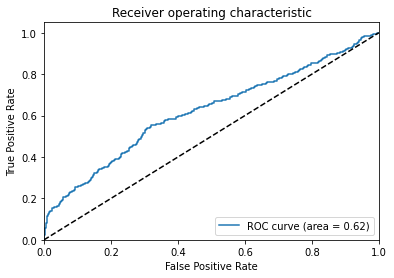

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
#y_true = np.array([0]*500+[1]*500)
fpr,tpr,thresholds = roc_curve(ground_truth,probs)
roc_auc = auc(fpr,tpr)
fnr = 1-tpr
abs_diffs = np.abs(fpr - fnr)
min_index = np.argmin(abs_diffs)
eer = np.mean((fpr[min_index], fnr[min_index]))
print(eer)
plt.figure()

plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
probs

array([0.73309226, 0.9293817 , 0.95274116, ..., 0.45374228, 0.14793625,
       0.10028579])

In [ ]:
np.mean(fpr)

0.49740359162139475

In [ ]:
np.mean(fnr)

0.4944334813686241

In [ ]:
np.mean(tpr)

0.5055665186313759

In [ ]:
confusion_matrix(ground_truth,predictions)

array([[  83, 1565],
       [  21,  341]])

In [ ]:
with open("/content/drive/MyDrive/ls_test.pickle", "rb") as fp:   #Pickling

  ls_test = pickle.load(fp)

In [ ]:
ground_truth = []
for i in ls_test:
  folder,file = i.split("/")[-2:]
  print(folder)
  print(file)
  print(int(file.split(".")[0]))
  if folder in a.keys():
    ground_truth.append(a[folder][int(file.split(".")[0])-1])



Streaming output truncated to the last 5000 lines.
166.tif
166
Test012
147.tif
147
Test012
056.tif
56
Test012
060.tif
60
Test012
047.tif
47
Test012
010.tif
10
Test012
159.tif
159
Test012
069.tif
69
Test012
126.tif
126
Test012
006.tif
6
Test012
081.tif
81
Test012
076.tif
76
Test012
005.tif
5
Test012
078.tif
78
Test012
067.tif
67
Test012
022.tif
22
Test012
049.tif
49
Test012
031.tif
31
Test012
090.tif
90
Test012
089.tif
89
Test012
030.tif
30
Test012
029.tif
29
Test012
142.tif
142
Test012
136.tif
136
Test012
149.tif
149
Test012
145.tif
145
Test012
151.tif
151
Test012
048.tif
48
Test012
026.tif
26
Test012
024.tif
24
Test012
152.tif
152
Test012
083.tif
83
Test012
046.tif
46
Test012
091.tif
91
Test012
114.tif
114
Test012
153.tif
153
Test012
124.tif
124
Test012
115.tif
115
Test012
014.tif
14
Test012
084.tif
84
Test012
041.tif
41
Test012
130.tif
130
Test012
040.tif
40
Test012
063.tif
63
Test012
050.tif
50
Test012
131.tif
131
Test012
034.tif
34
Test012
042.tif
42
Test012
065.tif
65
Test012
158.

In [ ]:
ground_truth

[-1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 1,
 -1,
 1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -1,
 -

In [ ]:
len(ground_truth)

2010

In [ ]:
#gt
# a= {"test1":test1}
test1=[1]*60+[-1]*120
test2=[1]*94+[-1]*86
test3=[-1]*146+[1]*4
test4=[1]*30+[-1]*150
test5=[-1]*129+[1]*21
test6=[-1]*159+[1]*21
test7=[1]*45+[-1]*(180-46+1)
test8=[-1]*180
test9=[-1]*120
test10=[-1]*150
test11=[-1]*180
test12=[1]*87+[-1]*(180-88+1)

frame_gt_list=test1+test2+test3+test4+test5+test6+test7+test8+test9+test10+test11+test12

In [ ]:
test10[149]

-1

In [ ]:
a= {"Test001":test1,"Test002":test2,"Test003":test3,"Test004":test4,"Test005":test5,"Test006":test6,"Test007":test7,"Test008":test8,"Test009":test9,"Test010":test10,"Test011":test11,"Test012":test12,}


In [ ]:
ls_test

['/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test010/113.tif',
 '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test010/117.tif',
 '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test010/150.tif',
 '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test010/074.tif',
 '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test010/044.tif',
 '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test010/134.tif',
 '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test010/144.tif',
 '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test010/138.tif',
 '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test010/122.tif',
 '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test010/110.tif',
 '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test010/032.tif',
 '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test010/033.tif',
 '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test010/038.tif',
 '/content/UCSD_Anomaly_Dataset.v1p2/UCSDped2/Test/Test010/071.tif',
 '/content/UCSD_Anomaly_Dataset.v1

In [ ]:
import pickle
with open("/content/drive/MyDrive/vec_test.pickle","rb") as f:

  vec = pickle.load(f)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


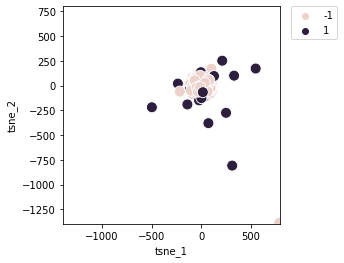

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# We want to get TSNE embedding with 2 dimensions
n_components = 3
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(vec_flatten_test)
tsne_result.shape
# (1000, 2)
# Two dimensions for each of our images
 
# Plot the result of our TSNE with the label color coded
# A lot of the stuff here is about making the plot look pretty and not TSNE
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': ground_truth})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-10, tsne_result.max()+10)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)
